In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('./data/')
sys.path.append('./models/')

from baseline import *
import pickle
with open('./data/dict_data_final.pkl', 'rb') as f:
    data = pickle.load(f)

__, y = data['Beneixama']
x = pd.read_csv('data_beneixama.csv', index_col=0)
x['Train'] = __['Train'].values

In [2]:
sus_y = np.array([(y[:, :, i] != 0).sum().item() for i in range(y.shape[2])])
abs_y = np.argwhere(x.Train.values == True).flatten()

In [3]:
P1 = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01]
C1 = 1.5

grid = Grid(x=x, y=y)
grid.initialize(part=P1, div=C1)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

base_sus_y = np.array([torch.sum(grid.X[:, :, i]) for i in abs_y])
c_base = grid.div

diff_base = base_sus_y - sus_y

In [4]:
grid = Grid(x=x, y=y, mode='gumbel')
grid.initialize(part=P1, div=C1)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

base_sus_y_g = np.array([torch.sum(grid.X[:, :, i]) for i in abs_y])

diff_base_g = base_sus_y_g - sus_y

In [5]:
diff_base, diff_base_g

(array([   0, -166, -272, -338, -405,  528, 1731, 3299, 6958], dtype=int64),
 array([   0, -165, -270, -333, -400,  543, 1744, 3314, 6894], dtype=int64))

In [6]:
from thmodel import *

In [7]:
grid = Grid(x=x, y=y)
grid.initialize(part=P1)
grid.compute_th_param(alpha=0.5, beta=0.5, gamma=0.5)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

th_sus_y = np.array([torch.sum(grid.X[:, :, i]) for i in abs_y])
c_th = grid.div

diff_th = th_sus_y - sus_y

In [8]:
grid = Grid(x=x, y=y, mode='gumbel')
grid.initialize(part=P1)
grid.compute_th_param(alpha=0.5, beta=0.5, gamma=0.5)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

th_sus_y_g = np.array([torch.sum(grid.X[:, :, i]) for i in abs_y])

diff_th_g = th_sus_y_g - sus_y

In [9]:
diff_th, diff_th_g

(array([   0, -162, -256, -306, -353,  692, 2021, 3735, 7181], dtype=int64),
 array([   0, -160, -252, -302, -347,  703, 2034, 3752, 7199], dtype=int64))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


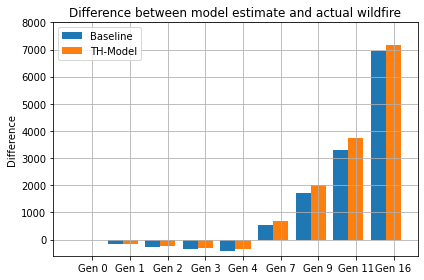

In [33]:
mode = ['Gen ' + str(i) for i in abs_y]
values = {
    'Baseline': diff_base,
    'TH-Model': diff_th
}

x_ = np.arange(len(mode))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x_ + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Difference')
ax.set_title('Difference between model estimate and actual wildfire')
ax.set_xticks(x_ + width, mode)
ax.legend(loc='upper left')
ax.set_ylim(-600, 8000)
ax.grid()

fig.tight_layout()
fig.savefig('diff_evoluition.png', dpi=300)
fig.savefig('diff_evoluition.eps', dpi=300)

In [16]:
c_base = np.array([c_base for i in range(17)])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


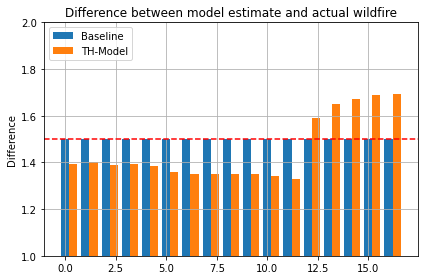

In [35]:
values = {
    'Baseline': c_base,
    'TH-Model': c_th.numpy()
}

x_ = np.arange(len(c_th.numpy()))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x_ + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Difference')
ax.set_title('Difference between model estimate and actual wildfire')
ax.legend(loc='upper left')
ax.axhline(y=1.5, color='r', linestyle='--')
ax.set_ylim(1, 2)
ax.grid()

fig.tight_layout()
fig.savefig('diff_evoluition_C.png', dpi=300)
fig.savefig('diff_evoluition_C.eps', dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


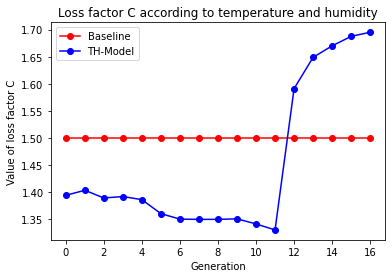

In [44]:
plt.plot(x_, c_base, 'ro-', label='Baseline')
plt.plot(x_, c_th.numpy(), 'bo-', label='TH-Model')
plt.ylabel('Value of loss factor C')
plt.xlabel('Generation')
plt.title('Loss factor C according to temperature and humidity')
plt.legend()
plt.savefig('lossfactor_evolution.png', dpi=300)
plt.savefig('lossfactor_evolution.eps', dpi=300)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_errors(X, Y, name='mask_errors'):
    """
    Crea un gráfico mostrando los errores en la comparación entre X e Y.
    
    Parametros:
        X (numpy array): Primera matriz binaria.
        Y (numpy array): Segunda matriz binaria.
    """

    # Verificar que X e Y tengan las mismas dimensiones
    assert X.shape == Y.shape, "X e Y deben tener las mismas dimensiones."

    # Calcular la diferencia entre X e Y para obtener los diferentes tipos de errores
    diff = X - Y

    # Asignar colores específicos a cada tipo de error
    cmap = plt.cm.colors.ListedColormap(['red', 'green', 'blue'])
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Crear la imagen del gráfico con colores personalizados
    plt.imshow(diff, cmap=cmap, norm=norm)

    # Crear una leyenda para los tipos de errores
    legend_labels = ['Correct', 'FN', 'FP']
    colors = ['green', 'red', 'blue']
    patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in colors]
    plt.legend(patches, legend_labels, loc='upper right')
    # plt.savefig(name , format='eps', dpi=300)

    # Mostrar el gráfico
    plt.show()

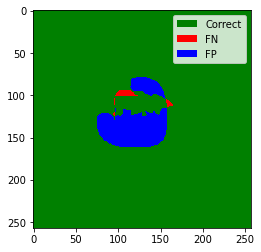

In [12]:
X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plot_confusion_errors(X, Y, name='figures\mask_errors_p2.eps')